In [1]:
machine = 'mac'
machine = 'magny'

In [3]:
if machine == 'magny':
    filedir = "/home/extmilan/masterthesis/files/"
    basedir = "/hits/universe/GigaGalaxy/level4_MHD/"
elif machine == 'mac':
    filedir = "/Users/smilanov/Documents/masterthesis/auriga_files/files/"
    basedir = "/Users/smilanov/Desktop/Auriga/level4/"
else:
    raise NotADirectoryError

In [2]:
from galpy.potential import MiyamotoNagaiPotential, NFWPotential, HernquistPotential
from galpy.actionAngle import estimateDeltaStaeckel, actionAngleStaeckel

from areposnap.gadget import gadget_readsnap
from areposnap.gadget_subfind import load_subfind

from auriga_basics import *
from auriga_functions import *

import numpy as np
from IPython.display import Image, display

import corner

import datetime

%matplotlib inline

In [4]:
#### path = /hits/universe/GigaGalaxy/level4_MHD/halo_24/output/*
level = 4

j = 0
for halo_number in [24]:  # range(1, 31):
    halodir = basedir+"halo_{0}/".format(halo_number)
    snappath = halodir+"output/"
    for snapnr in range(127,128,1):
        print("level   : {0}".format(level))
        print("halo    : {0}".format(halo_number))
        print("snapnr  : {0}".format(snapnr))
        print("basedir : {0}".format(basedir))
        print("halodir : {0}".format(halodir))
        print("snappath: {0}\n".format(snappath))
        s, sf = eat_snap_and_fof(level, halo_number, snapnr, snappath, loadonlytype=[0,1,2,3,4,5], 
            haloid=0, galradfac=0.1, verbose=True) 

        # Clean negative and zero values of gmet to avoid RuntimeErrors
        # later on (e.g. dividing by zero)
        s.data['gmet'] = np.maximum( s.data['gmet'], 1e-40 )
     

level   : 4
halo    : 24
snapnr  : 127
basedir : /Users/smilanov/Desktop/Auriga/level4/
halodir : /Users/smilanov/Desktop/Auriga/level4/halo_24/
snappath: /Users/smilanov/Desktop/Auriga/level4/halo_24/output/

[ 34.42281723  33.16259384  37.29567337]
Found 1783163 stars.
Rotated pos.
Rotated bfld.
Rotated vel.

galrad  : 0.02408556640148163
redshift: 2.220446049250313e-16
time    : 0.9999999999999998
center  : [ 0.  0.  0.]



In [5]:
#_____reference values for galpy_____
_REFR0_kpc = 8.

#_____function that sets-up galpy potential_____
def setup_galpy_potential(a_MND_kpc,b_MND_kpc,a_NFWH_kpc,a_HB_kpc,n_MND,n_NFWH,n_HB):
    
    #test input:
    if (a_MND_kpc <= 0.) or (b_MND_kpc <= 0.) or (a_NFWH_kpc <= 0.) or (a_HB_kpc <= 0.) \
       or (n_MND <= 0.) or (n_NFWH <= 0.) or (n_HB <= 0.) or (n_MND >= 1.) or (n_NFWH >= 1.) or (n_HB >= 1.):
        raise ValueError('Error in setup_galpy_potential: '+\
                         'The input parameters for the scaling profiles do not correspond to a physical potential.')
    if np.fabs(n_MND + n_NFWH + n_HB - 1.) > 1e-7:
        raise ValueError('Error in setup_galpy_potential: '+\
                         'The sum of the normalization does not add up to 1.')
        
    #trafo to galpy units:
    a_MND  = a_MND_kpc/_REFR0_kpc
    b_MND  = b_MND_kpc/_REFR0_kpc
    a_NFWH = a_NFWH_kpc/_REFR0_kpc
    a_HB   = a_HB_kpc/_REFR0_kpc
    
    #setup potential:
    disk = MiyamotoNagaiPotential(
                a=a_MND,
                b=b_MND,
                normalize=n_MND)
    halo = NFWPotential(
                a=a_NFWH,
                normalize=n_NFWH)
    bulge = HernquistPotential(
                a=a_HB,
                normalize=n_HB)
    return [disk,halo,bulge]
    #return [disk,halo]

Action evolution parameters
---

- IDlist (somehow.... find where dwarf (67 für den Anfangs) merges)
- startnr
- fit routine = emcxee 1 (in v0.1; more maybe in v0.2)
- delta fix or calculation
- figure (with labels, range, title etc predefined)
- in v0.2 possibility for wrong potential


In [ ]:
pot_params = np.loadtxt(filedir + 'potential_params.txt')
# wenn dann das file richtig ist funktioniert folgendes (hoffentlich):

snapnr          = pot_params[0, :]
v0_kms          = pot_params[1, :]
v0_kms_err      = pot_params[2, :]
a_MND_kpc       = pot_params[3, :]
a_MND_kpc_err   = pot_params[4, :]
b_MND_kpc       = pot_params[5, :]
b_MND_kpc_err   = pot_params[6, :]
a_NFWH_kpc      = pot_params[7, :]
a_NFWH_kpc_err  = pot_params[8, :]
a_HB_kpc        = pot_params[9, :]
a_HB_kpc_err    = pot_params[10, :]
n_MND           = pot_params[11, :]
n_MND_err       = pot_params[12, :]
n_NFWH          = pot_params[13, :]
n_NFWH_err      = pot_params[14, :]
n_HB            = pot_params[15, :]
n_HB_err        = pot_params[16, :]

snapnr = np.array(snapnr, dtype = int)

In [ ]:
# schau die animationsdokumentation genauer an um zu sehen was ich wann einlesen muss und worueber gelooped werden muss
# entweder save as files oder finde einen anderen weg, wie ich die ids kriege 
def plot_action_corner():
    

In [ ]:
#### path = /hits/universe/GigaGalaxy/level4_MHD/halo_24/output/*

### ____ fit actions to stars so only load type 4 ____

level = 4

startnr = 72 # nr of snapshot where dwarf is first merged

j = 0
for halo_number in [24]:  # range(1, 31):
    halodir = basedir+"halo_{0}/".format(halo_number)
    snappath = halodir+"output/"
    for snapnr in range(startnr,128,1):
        print("snapnr  : {0}".format(snapnr))
        print(datetime.datetime.now().time())
        try:
            s, sf = eat_snap_and_fof(level, halo_number, snapnr, snappath, loadonlytype=[4], 
            haloid=0, galradfac=0.1, verbose=False) 
        except KeyError:
            print('\n\n', snapnr, 'not read in.\n\n')
            continue

        # Clean negative and zero values of gmet to avoid RuntimeErrors
        # later on (e.g. dividing by zero)
        s.data['gmet'] = np.maximum( s.data['gmet'], 1e-40 )
        '''
        if j == 0:
            # initialize figure if not given as input
            j +=1
        else:
        '''

In [ ]:
### write a function out of the routine above
# read in ID lists generated in notebook 2dwarf

#def 

org_dwarfs = ['67', '73']
pot_fit_routines = ['diff_ev', 'emcee1', 'emcee2']
repeater = 0
for routine in pot_fit_routines:
    init = 0

    for num in org_dwarfs:
        if num == '57':
            color = 'red'
        elif num == '67':
            color = 'blue'
        elif num == '73':
            color = 'green'            
        ids_notused = np.loadtxt(filedir + 'surviving_ids_snapshot_' + num + '_sh_1.txt', dtype = 'int') # 2648 particles 
        ids = np.loadtxt(filedir + 'surviving_ids_zsignchange_snapshot_' + num + '_sh_1.txt', dtype = 'int') # 93 particles

        id_list = [ids_notused] #ids

        # read in the different results of the different fitting routines of notebook 1pot
        
        if routine == 'diff_ev':
            v0_kms, a_MND_kpc, b_MND_kpc, a_NFWH_kpc, a_HB_kpc, n_MND, n_NFWH, n_HB = np.loadtxt(filedir + 'pot_res_diff_ev.txt')
            title = 'differential evolution'
        elif routine == 'emcee1':
            repeater = 1
            v0_kms, a_MND_kpc, b_MND_kpc, a_NFWH_kpc, a_HB_kpc, n_MND, n_NFWH, n_HB = np.loadtxt(filedir + 'pot_res_emcee1.txt')
            title = '1st MCMC'
        elif routine == 'emcee2':
            v0_kms, a_MND_kpc, b_MND_kpc, a_NFWH_kpc, a_HB_kpc, n_MND, n_NFWH, n_HB = np.loadtxt(filedir + 'pot_res_emcee2.txt')
            title = '2nd MCMC'
        else:
            raise FileNotFoundError  

        _REFV0_kms = v0_kms

        pot_galpy = setup_galpy_potential(a_MND_kpc, b_MND_kpc, a_NFWH_kpc, a_HB_kpc, n_MND, n_NFWH, n_HB)
        for ID in id_list:    
            gcmask = np.isin(s.id, ID)

            if np.sum(gcmask) == 0:
                continue
            # get position and velocities of all selected GCs & convert to galpy units
            (R_kpc, phi_rad, z_kpc), (vR_kms, vphi_kms, vz_kms) = get_cylindrical_vectors(s, sf, gcmask)
            R_galpy, vR_galpy, vT_galpy, z_galpy, vz_galpy = R_kpc / _REFR0_kpc, vR_kms / _REFV0_kms, vphi_kms / _REFV0_kms, z_kpc / _REFR0_kpc, vz_kms / _REFV0_kms

            # estimate Delta of the Staeckel potential
            delta = estimateDeltaStaeckel(pot_galpy, R_galpy, z_galpy)

            # set up the actionAngleStaeckel object
            aAS = actionAngleStaeckel(
                    pot   = pot_galpy,  # potential
                    delta = delta,      # focal length of confocal coordinate system
                    c     = True        # use C code (for speed)
                    )
            # calculate actions (in galpy units) & convert them to physical units
            r_condition = np.where((np.sqrt(R_kpc**2 + z_kpc**2)) <= 50.)
            
            jR_galpy, lz_galpy, jz_galpy = aAS(R_galpy[r_condition], vR_galpy[r_condition], vT_galpy[r_condition], z_galpy[r_condition], vz_galpy[r_condition])
            jR_kpckms, lz_kpckms, jz_kpckms = jR_galpy * _REFR0_kpc * _REFV0_kms, lz_galpy * _REFR0_kpc * _REFV0_kms, jz_galpy * _REFR0_kpc * _REFV0_kms

            # prepare data for plotting and create corner plot
            data = np.vstack([jR_kpckms, lz_kpckms, jz_kpckms])
            labels = ['jR [kpc km/s]', 'lz [kpc km/s]', 'jz [kpc km/s]']
            if init == 0:
                figure = corner.corner(data.transpose(), labels = labels, plot_contours = 1, color = color, range =  [(0.,12500.), (-14000.,14000.),(0., 5000.)])
                init +=1
            else:
                figure = corner.corner(data.transpose(), labels = labels, plot_contours = 1, color = color, fig = figure, range =  [(0.,12500.), (-14000.,14000.),(0., 5000.)])            
            #figure.suptitle(num + ' ' + title + '\nnumber of GCs: ' + str(len(R_kpc[r_condition])) + '\n$\Delta$ Staeckel: ' + "{:2.2f}".format(delta));
            
            #display(figure)
            if repeater == 0:
                print('number of all selected GCs', np.sum(gcmask), 'num of GCs within 50kpc:', len(r_condition[0]))
    '''            
    #MW potential
    from galpy.potential import MWPotential
    MWV0_kms = 220

    # estimate Delta of the Staeckel potential
    delta = estimateDeltaStaeckel(MWPotential, R_galpy, z_galpy)

    # set up the actionAngleStaeckel object
    aAS = actionAngleStaeckel(
            pot   = MWPotential,  # potential
            delta = delta,      # focal length of confocal coordinate system
            c     = True        # use C code (for speed)
            )
    # calculate actions (in galpy units) & convert them to physical units
    r_condition = np.where((R_kpc + z_kpc) <= 50.)

    jR_galpy, lz_galpy, jz_galpy = aAS(R_galpy[r_condition], vR_galpy[r_condition], vT_galpy[r_condition], z_galpy[r_condition], vz_galpy[r_condition])
    jR_kpckms, lz_kpckms, jz_kpckms = jR_galpy * _REFR0_kpc * MWV0_kms, lz_galpy * _REFR0_kpc * MWV0_kms, jz_galpy * _REFR0_kpc * MWV0_kms

    data = np.vstack([jR_kpckms, lz_kpckms, jz_kpckms])
    labels = ['jR [kpc km/s]', 'lz [kpc km/s]', 'jz [kpc km/s]']
    figure = corner.corner(data.transpose(), labels = labels, plot_contours = 1, color = 'black', fig = figure)            
    
    
    '''

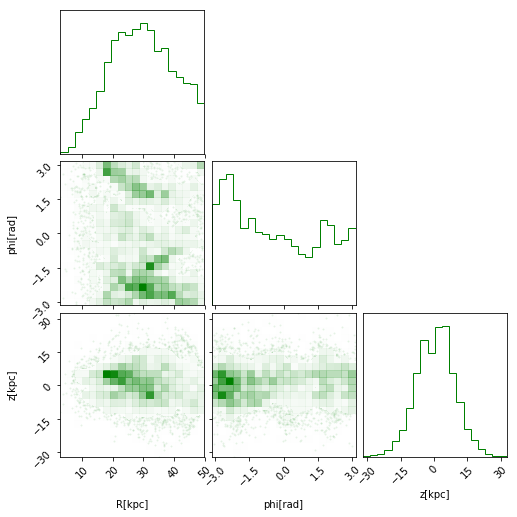

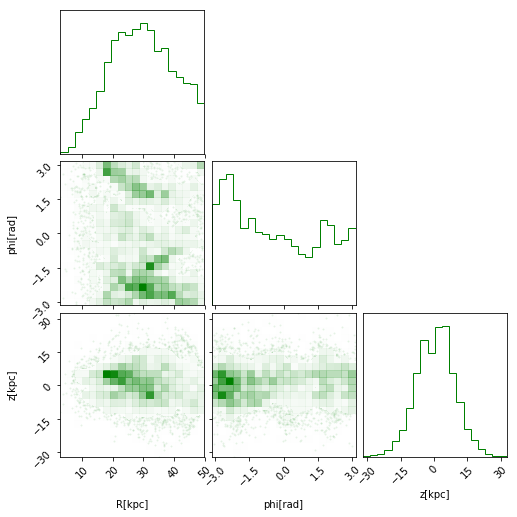

In [8]:
data = np.vstack([R_kpc[r_condition], phi_rad[r_condition], z_kpc[r_condition]])
labels = ['R[kpc]', 'phi[rad]', 'z[kpc]']
corner.corner(data.transpose(), labels = labels, plot_contours = 0, color = color)

number of all selected GCs 2648 num of GCs within 50kpc: 1365
number of all selected GCs 9785 num of GCs within 50kpc: 5006


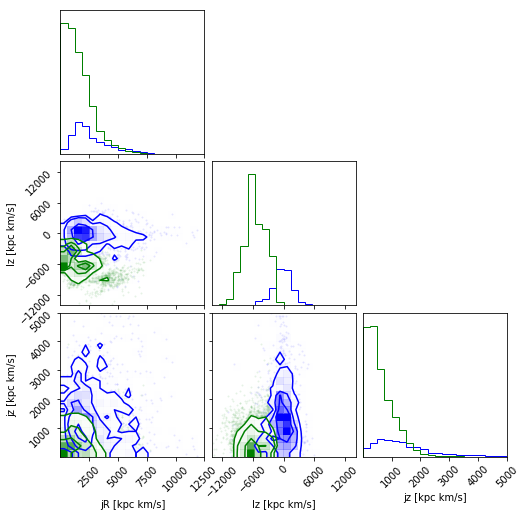

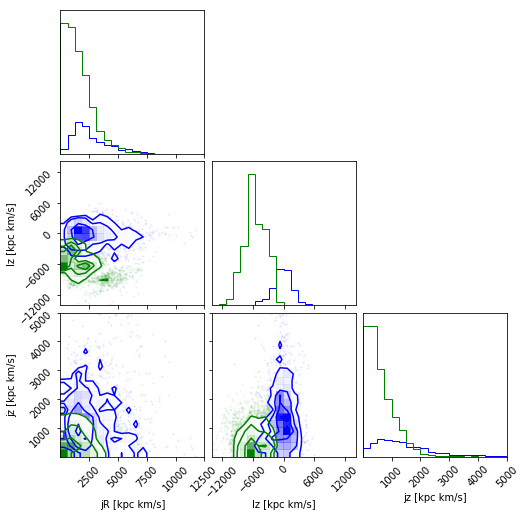

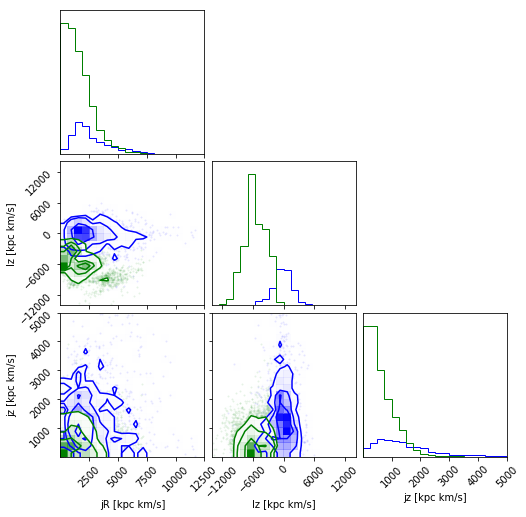

In [7]:
# read in ID lists generated in notebook 2dwarf
org_dwarfs = ['67', '73']
pot_fit_routines = ['diff_ev', 'emcee1', 'emcee2']
repeater = 0
for routine in pot_fit_routines:
    init = 0

    for num in org_dwarfs:
        if num == '57':
            color = 'red'
        elif num == '67':
            color = 'blue'
        elif num == '73':
            color = 'green'            
        ids_notused = np.loadtxt(filedir + 'surviving_ids_snapshot_' + num + '_sh_1.txt', dtype = 'int') # 2648 particles 
        ids = np.loadtxt(filedir + 'surviving_ids_zsignchange_snapshot_' + num + '_sh_1.txt', dtype = 'int') # 93 particles

        id_list = [ids_notused] #ids

        # read in the different results of the different fitting routines of notebook 1pot
        
        if routine == 'diff_ev':
            v0_kms, a_MND_kpc, b_MND_kpc, a_NFWH_kpc, a_HB_kpc, n_MND, n_NFWH, n_HB = np.loadtxt(filedir + 'pot_res_diff_ev.txt')
            title = 'differential evolution'
        elif routine == 'emcee1':
            repeater = 1
            v0_kms, a_MND_kpc, b_MND_kpc, a_NFWH_kpc, a_HB_kpc, n_MND, n_NFWH, n_HB = np.loadtxt(filedir + 'pot_res_emcee1.txt')
            title = '1st MCMC'
        elif routine == 'emcee2':
            v0_kms, a_MND_kpc, b_MND_kpc, a_NFWH_kpc, a_HB_kpc, n_MND, n_NFWH, n_HB = np.loadtxt(filedir + 'pot_res_emcee2.txt')
            title = '2nd MCMC'
        else:
            raise FileNotFoundError  

        _REFV0_kms = v0_kms

        pot_galpy = setup_galpy_potential(a_MND_kpc, b_MND_kpc, a_NFWH_kpc, a_HB_kpc, n_MND, n_NFWH, n_HB)
        for ID in id_list:    
            gcmask = np.isin(s.id, ID)

            if np.sum(gcmask) == 0:
                continue
            # get position and velocities of all selected GCs & convert to galpy units
            (R_kpc, phi_rad, z_kpc), (vR_kms, vphi_kms, vz_kms) = get_cylindrical_vectors(s, sf, gcmask)
            R_galpy, vR_galpy, vT_galpy, z_galpy, vz_galpy = R_kpc / _REFR0_kpc, vR_kms / _REFV0_kms, vphi_kms / _REFV0_kms, z_kpc / _REFR0_kpc, vz_kms / _REFV0_kms

            # estimate Delta of the Staeckel potential
            delta = estimateDeltaStaeckel(pot_galpy, R_galpy, z_galpy)

            # set up the actionAngleStaeckel object
            aAS = actionAngleStaeckel(
                    pot   = pot_galpy,  # potential
                    delta = delta,      # focal length of confocal coordinate system
                    c     = True        # use C code (for speed)
                    )
            # calculate actions (in galpy units) & convert them to physical units
            r_condition = np.where((np.sqrt(R_kpc**2 + z_kpc**2)) <= 50.)
            
            jR_galpy, lz_galpy, jz_galpy = aAS(R_galpy[r_condition], vR_galpy[r_condition], vT_galpy[r_condition], z_galpy[r_condition], vz_galpy[r_condition])
            jR_kpckms, lz_kpckms, jz_kpckms = jR_galpy * _REFR0_kpc * _REFV0_kms, lz_galpy * _REFR0_kpc * _REFV0_kms, jz_galpy * _REFR0_kpc * _REFV0_kms

            # prepare data for plotting and create corner plot
            data = np.vstack([jR_kpckms, lz_kpckms, jz_kpckms])
            labels = ['jR [kpc km/s]', 'lz [kpc km/s]', 'jz [kpc km/s]']
            if init == 0:
                figure = corner.corner(data.transpose(), labels = labels, plot_contours = 1, color = color, range =  [(0.,12500.), (-14000.,14000.),(0., 5000.)])
                init +=1
            else:
                figure = corner.corner(data.transpose(), labels = labels, plot_contours = 1, color = color, fig = figure, range =  [(0.,12500.), (-14000.,14000.),(0., 5000.)])            
            #figure.suptitle(num + ' ' + title + '\nnumber of GCs: ' + str(len(R_kpc[r_condition])) + '\n$\Delta$ Staeckel: ' + "{:2.2f}".format(delta));
            
            #display(figure)
            if repeater == 0:
                print('number of all selected GCs', np.sum(gcmask), 'num of GCs within 50kpc:', len(r_condition[0]))
    '''            
    #MW potential
    from galpy.potential import MWPotential
    MWV0_kms = 220

    # estimate Delta of the Staeckel potential
    delta = estimateDeltaStaeckel(MWPotential, R_galpy, z_galpy)

    # set up the actionAngleStaeckel object
    aAS = actionAngleStaeckel(
            pot   = MWPotential,  # potential
            delta = delta,      # focal length of confocal coordinate system
            c     = True        # use C code (for speed)
            )
    # calculate actions (in galpy units) & convert them to physical units
    r_condition = np.where((R_kpc + z_kpc) <= 50.)

    jR_galpy, lz_galpy, jz_galpy = aAS(R_galpy[r_condition], vR_galpy[r_condition], vT_galpy[r_condition], z_galpy[r_condition], vz_galpy[r_condition])
    jR_kpckms, lz_kpckms, jz_kpckms = jR_galpy * _REFR0_kpc * MWV0_kms, lz_galpy * _REFR0_kpc * MWV0_kms, jz_galpy * _REFR0_kpc * MWV0_kms

    data = np.vstack([jR_kpckms, lz_kpckms, jz_kpckms])
    labels = ['jR [kpc km/s]', 'lz [kpc km/s]', 'jz [kpc km/s]']
    figure = corner.corner(data.transpose(), labels = labels, plot_contours = 1, color = 'black', fig = figure)            
    
    
    '''